In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

In [2]:
#load csv and print shape
csv_datei = '../data/mushrooms.csv'
df = pd.read_csv(csv_datei)
print(df.shape)

(8124, 23)


In [3]:
# print all unique values and cout
for spalte in df.columns:
    print(f"\nSpalte: {spalte}")
    print(df[spalte].value_counts(dropna=False))


Spalte: class
class
e    4208
p    3916
Name: count, dtype: int64

Spalte: cap-shape
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64

Spalte: cap-surface
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64

Spalte: cap-color
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64

Spalte: bruises
bruises
f    4748
t    3376
Name: count, dtype: int64

Spalte: odor
odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64

Spalte: gill-attachment
gill-attachment
f    7914
a     210
Name: count, dtype: int64

Spalte: gill-spacing
gill-spacing
c    6812
w    1312
Name: count, dtype: int64

Spalte: gill-size
gill-size
b    5612
n    2512
Name: count, dtype: int64

Spalte: gill-color
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e   

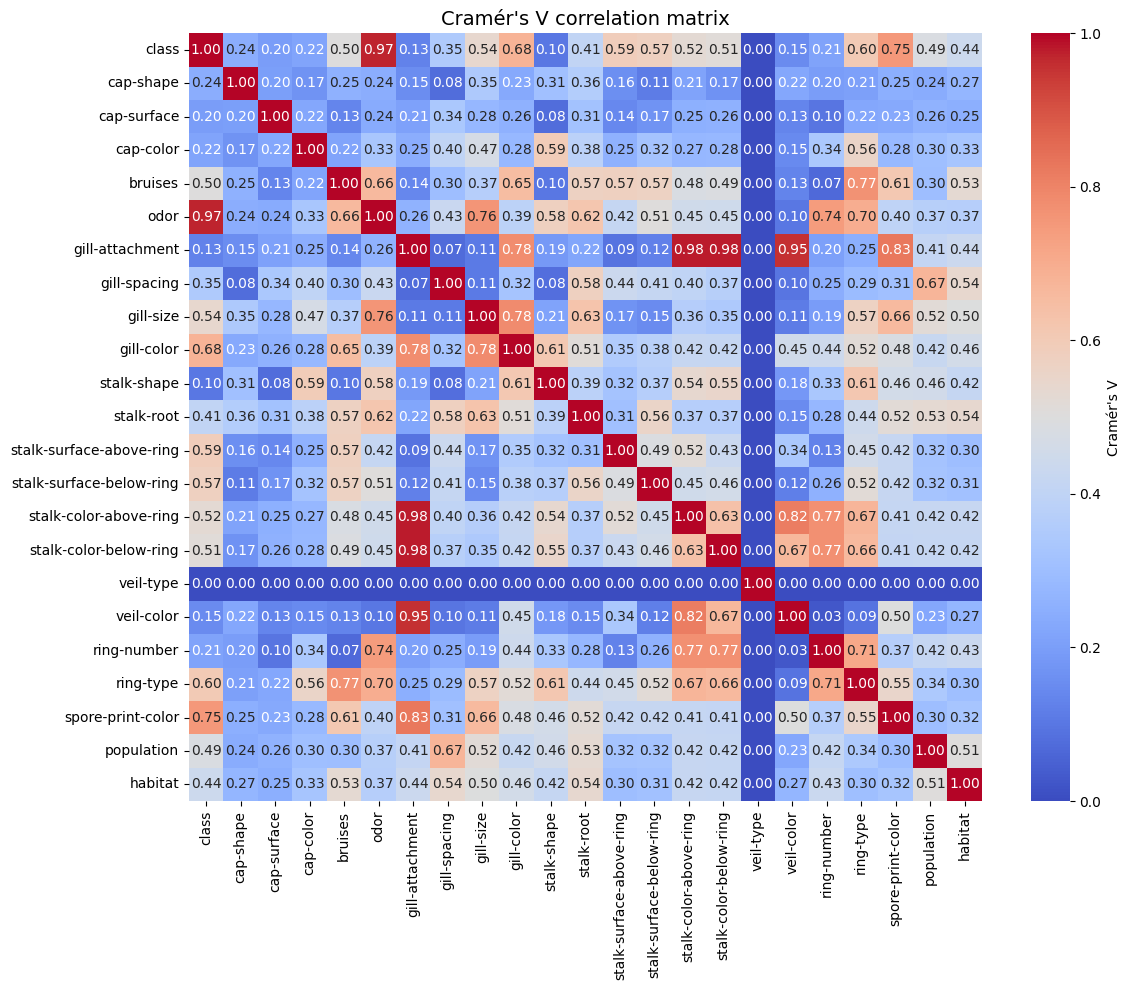

In [4]:
# cating everything as category
for c in df.columns:
    df[c] = df[c].astype('category')

# Cramér's V
def cramers_v_bias_corrected(x, y):
    table = pd.crosstab(x, y)
    if table.shape[0] < 2 or table.shape[1] < 2:
        return 0.0
    chi2, _, _, _ = chi2_contingency(table, correction=False)
    n = table.values.sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2_corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    r_corr = r - (r - 1) ** 2 / (n - 1)
    k_corr = k - (k - 1) ** 2 / (n - 1)
    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0:
        return 0.0
    return np.sqrt(phi2_corr / denom)

cat_cols = df.select_dtypes(include=['category', 'object', 'bool']).columns

# calculate matrix
matrix = pd.DataFrame(
    np.eye(len(cat_cols), dtype=float),
    index=cat_cols,
    columns=cat_cols
)

for i, col1 in enumerate(cat_cols):
    for j in range(i + 1, len(cat_cols)):
        col2 = cat_cols[j]
        v = cramers_v_bias_corrected(df[col1], df[col2])
        matrix.loc[col1, col2] = v
        matrix.loc[col2, col1] = v

# plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': "Cramér's V"})
plt.title("Cramér's V correlation matrix", fontsize=14)
plt.tight_layout()
plt.show()


In [5]:
#Preprocessing: dropping 'veil-type' and 'stalk-root'
df.drop(['veil-type','stalk-root'],axis=1)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,s,o,o,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,s,o,o,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,s,o,o,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,s,k,w,w,w,o,e,w,v,l


In [6]:
#Processing data for model usage

# Split in x and y
X = df.drop(['class'], axis=1)
y = df['class']

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42
)
print(X_train.shape)
# Features
categorical_features = X.columns.tolist()

# Encoding
ohe_encoder = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
ohe_dense = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])
ordinal_encoder = ColumnTransformer([
    ('cat', OrdinalEncoder(), categorical_features)
])


(5686, 22)


Categorical Naive Bayes:
              precision    recall  f1-score   support

           e       0.91      1.00      0.95      1257
           p       1.00      0.89      0.94      1181

    accuracy                           0.95      2438
   macro avg       0.95      0.94      0.95      2438
weighted avg       0.95      0.95      0.95      2438



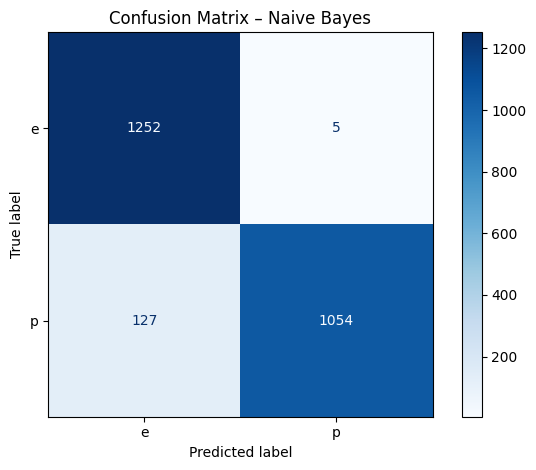

In [7]:
# ================================
# Categorical Naive Bayes
# ================================

nb_pipeline = Pipeline([
    ('encoder', ordinal_encoder),
    ('clf', CategoricalNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)
y_pred_nb_labels = label_encoder.inverse_transform(y_pred_nb)

print("Categorical Naive Bayes:")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_nb_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_nb_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – Naive Bayes")
plt.tight_layout()
plt.show()

Bernoulli Naive Bayes:
              precision    recall  f1-score   support

           e       0.90      0.99      0.94      1257
           p       0.98      0.88      0.93      1181

    accuracy                           0.93      2438
   macro avg       0.94      0.93      0.93      2438
weighted avg       0.94      0.93      0.93      2438



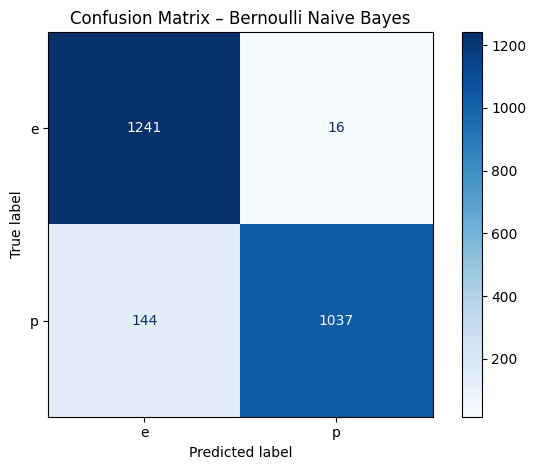

In [8]:
# ================================
# Bernoulli Naive Bayes
# ================================

bnb_pipeline = Pipeline([
    ('encoder', ohe_encoder),
    ('clf', BernoulliNB())
])

bnb_pipeline.fit(X_train, y_train)
y_pred_bnb = bnb_pipeline.predict(X_test)
y_pred_bnb_labels = label_encoder.inverse_transform(y_pred_bnb)

print("Bernoulli Naive Bayes:")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_bnb_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_bnb_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – Bernoulli Naive Bayes")
plt.tight_layout()
plt.show()


Gaussian Naive Bayes (nur kategorische Features):
              precision    recall  f1-score   support

           e       1.00      0.93      0.96      1257
           p       0.93      1.00      0.96      1181

    accuracy                           0.96      2438
   macro avg       0.97      0.97      0.96      2438
weighted avg       0.97      0.96      0.96      2438



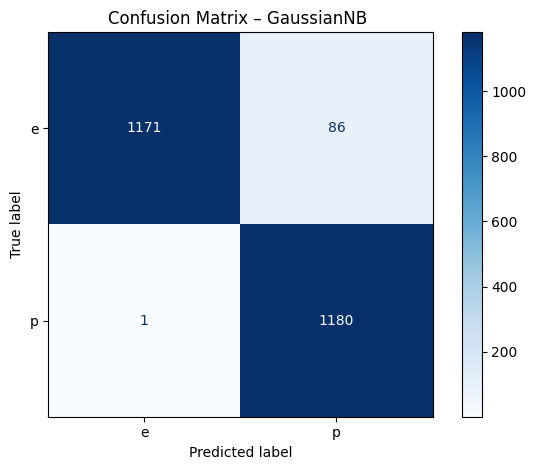

In [9]:
# ================================
# Gaussian Naive Bayes
# ================================

gnb_pipeline = Pipeline([
    ('encoder', ohe_dense),
    ('clf', GaussianNB())
])

gnb_pipeline.fit(X_train, y_train)
y_pred_gnb = gnb_pipeline.predict(X_test)
y_pred_gnb_labels = label_encoder.inverse_transform(y_pred_gnb)

print("Gaussian Naive Bayes (nur kategorische Features):")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_gnb_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_gnb_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – GaussianNB ")
plt.tight_layout()
plt.show()

Logistic Regression (L1):
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1257
           p       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



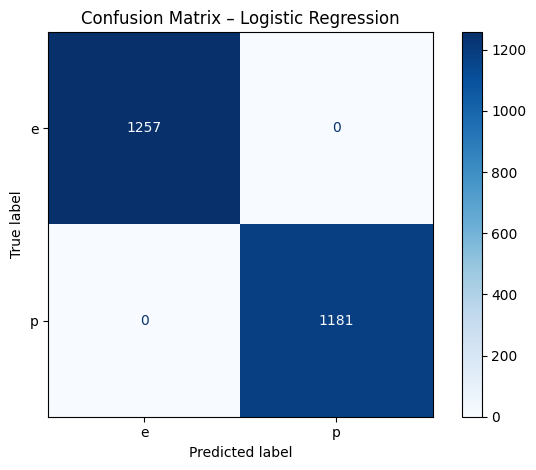

In [10]:
# ================================
# logististic regression
# ================================

logreg_pipeline = Pipeline([
    ('encoder', ohe_encoder),
    ('clf', LogisticRegression(max_iter=1000, penalty='l2', C=20))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)
y_pred_logreg_labels = label_encoder.inverse_transform(y_pred_logreg)

print("Logistic Regression (L1):")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_logreg_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_logreg_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()

Linear Discriminant Analysis (LDA):
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1257
           p       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



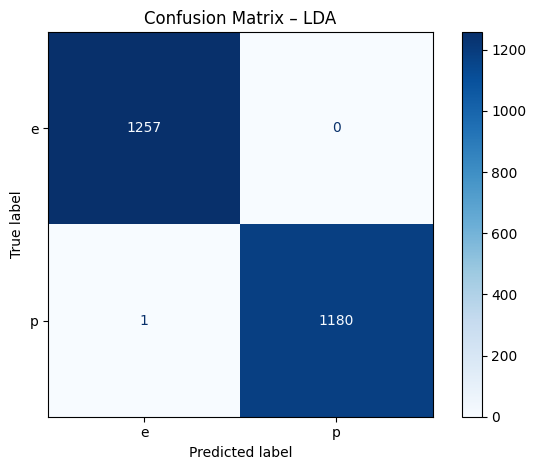

In [11]:
# ================================
# Linear Discriminant Analysis (LDA)
# ================================

lda_pipeline = Pipeline([
    ('encoder', ohe_dense),
    ('clf', LinearDiscriminantAnalysis())
])

lda_pipeline.fit(X_train, y_train)
y_pred_lda = lda_pipeline.predict(X_test)
y_pred_lda_labels = label_encoder.inverse_transform(y_pred_lda)

print("Linear Discriminant Analysis (LDA):")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_lda_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_lda_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – LDA")
plt.tight_layout()
plt.show()

/home/sc.uni-leipzig.de/tk51maga/.conda/envs/prob/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sc.uni-leipzig.de/tk51maga/.conda/envs/prob/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Quadratic Discriminant Analysis (QDA):
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1257
           p       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



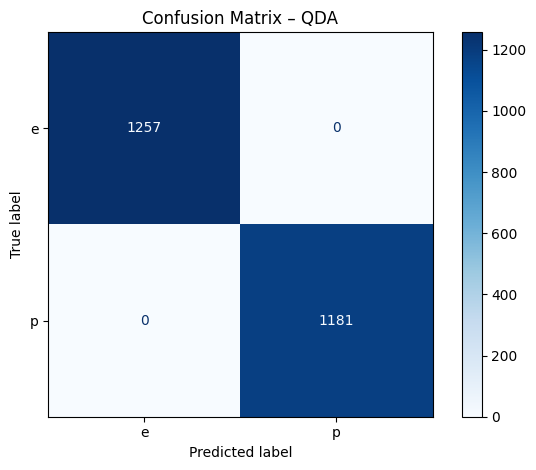

In [12]:
# ================================
# Quadratic Discriminant Analysis (QDA)
# ================================

qda_pipeline = Pipeline([
    ('encoder', ohe_dense),
    ('clf', QuadraticDiscriminantAnalysis())
])

qda_pipeline.fit(X_train, y_train)
y_pred_qda = qda_pipeline.predict(X_test)
y_pred_qda_labels = label_encoder.inverse_transform(y_pred_qda)

print("Quadratic Discriminant Analysis (QDA):")
print(classification_report(label_encoder.inverse_transform(y_test), y_pred_qda_labels))

cm = confusion_matrix(label_encoder.inverse_transform(y_test), y_pred_qda_labels)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix – QDA")
plt.tight_layout()
plt.show()

Min für True=1: 0.8152465225473539  | Max für True=0: 0.07141365696078297


/tmp/ipykernel_1851348/949787738.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([p_pos[y_bin==0], p_pos[y_bin==1]],


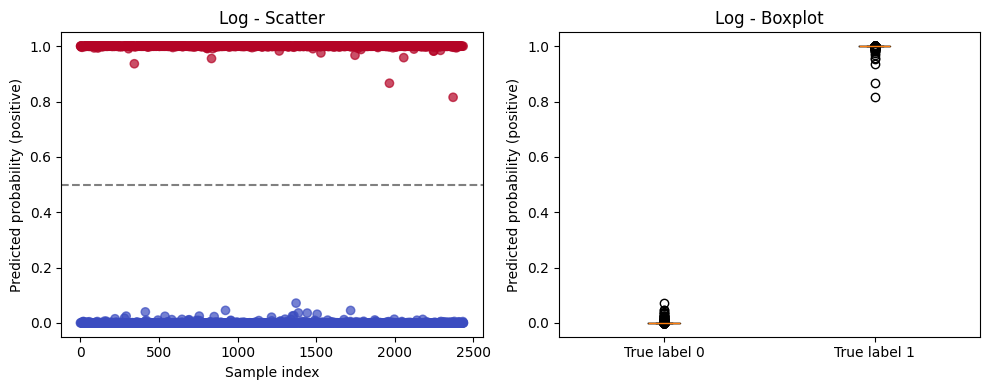

Min für True=1: 0.0  | Max für True=0: 0.0


/tmp/ipykernel_1851348/949787738.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([p_pos[y_bin==0], p_pos[y_bin==1]],


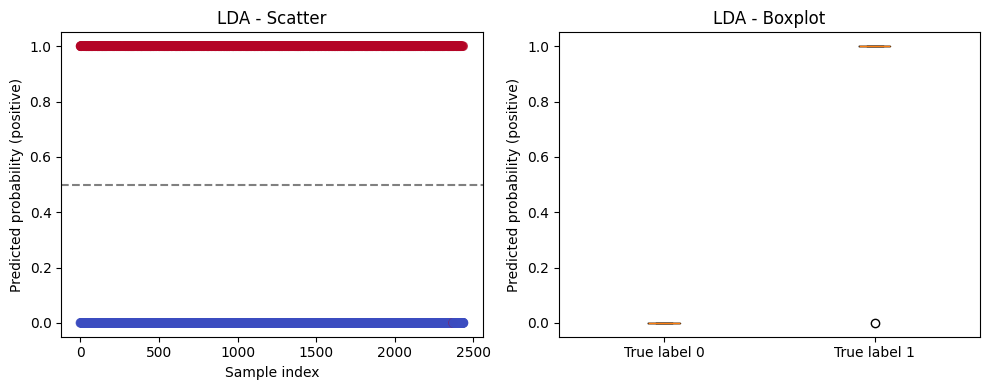

Min für True=1: 1.0  | Max für True=0: 0.0


/tmp/ipykernel_1851348/949787738.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([p_pos[y_bin==0], p_pos[y_bin==1]],


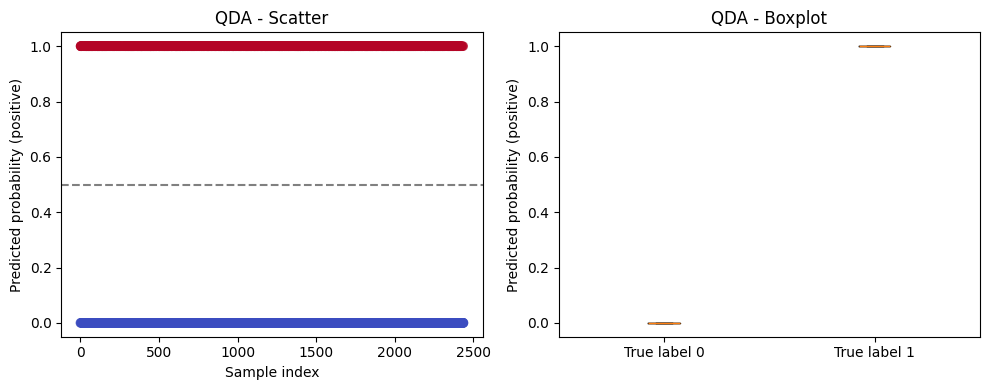

In [13]:
# Get probabilities for logreg,qda,lda
y_prob_qda = qda_pipeline.predict_proba(X_test)
y_prob_lda= lda_pipeline.predict_proba(X_test)
y_prob_logreg = logreg_pipeline.predict_proba(X_test)

# only for y=1
p_qda     = y_prob_qda[:, 1]
p_lda     = y_prob_lda[:, 1]
p_logreg  = y_prob_logreg[:, 1]


def plot_conf_vs_label(y_bin, p_pos, title):
    plt.figure(figsize=(10,4))

    #printing most confident Value(for misclassifications)
    print("Min für True=1:", p_pos[y_bin==1].min(), " | Max für True=0:", p_pos[y_bin==0].max())

    # Scatterplot
    plt.subplot(1,2,1)
    plt.scatter(range(len(y_bin)), p_pos, c=y_bin, cmap='coolwarm', alpha=0.7)
    plt.axhline(0.5, color='gray', linestyle='--')
    plt.xlabel("Sample index")
    plt.ylabel("Predicted probability (positive)")
    plt.title(f"{title} - Scatter")

    # Boxplot
    plt.subplot(1,2,2)
    plt.boxplot([p_pos[y_bin==0], p_pos[y_bin==1]],
                labels=['True label 0', 'True label 1'])
    plt.ylabel("Predicted probability (positive)")
    plt.title(f"{title} - Boxplot")

    plt.tight_layout()
    plt.show()


# plot logReg,QDA,LDA:
plot_conf_vs_label(y_test, p_logreg, "Log")
plot_conf_vs_label(y_test, p_lda, "LDA")
plot_conf_vs_label(y_test, p_qda, "QDA")

